# What the individual dimensions of a capsule represent

In [1]:
%matplotlib notebook

from keras import backend as K
from keras.datasets import mnist
from keras.models import load_model

from keras.layers import Input, Conv2D, Activation, Dense, Dropout, Lambda
from keras.layers import BatchNormalization, MaxPooling2D, Flatten
from convcaps.capslayers import ConvertToCaps, Conv2DCaps, FlattenCaps
from convcaps.capslayers import DenseCaps, CapsToScalars

from keras.utils import to_categorical
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive
import ipywidgets as widgets

from naive import do_routing
import tensorflow as tf

Using TensorFlow backend.


### Load dataset

In [2]:
img_rows, img_cols = 28, 28
num_classes = 10

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# since we use only tf the channel is last
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)
x_train /= 255
x_test /= 255

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

batch_size = 32

### Load pretrained model with encoder and decoder

In [7]:
custom_objects={'ConvertToCaps': ConvertToCaps,
                'Conv2DCaps': Conv2DCaps,
                'FlattenCaps': FlattenCaps,
                'DenseCaps': DenseCaps,
                'CapsToScalars': CapsToScalars,
                'tf': tf}

m_decoder = load_model('m_decoder8_tmp.hdf5', custom_objects=custom_objects, compile=False)
m_capsnet = load_model('m_capsnet8_tmp.hdf5', custom_objects=custom_objects, compile=False)
get_vecs = K.function([m_capsnet.input] + [K.learning_phase()],
                      [m_capsnet.layers[7].output])

In [8]:
p = get_vecs([x_train[:batch_size], False])[0]
pn = m_capsnet.predict(x_train[:batch_size]).argmax(axis=-1)

In [9]:
pv = np.array([p[n, pn[n]] for n in range(pn.shape[0])])

### Show generated digit

<IPython.core.display.Javascript object>


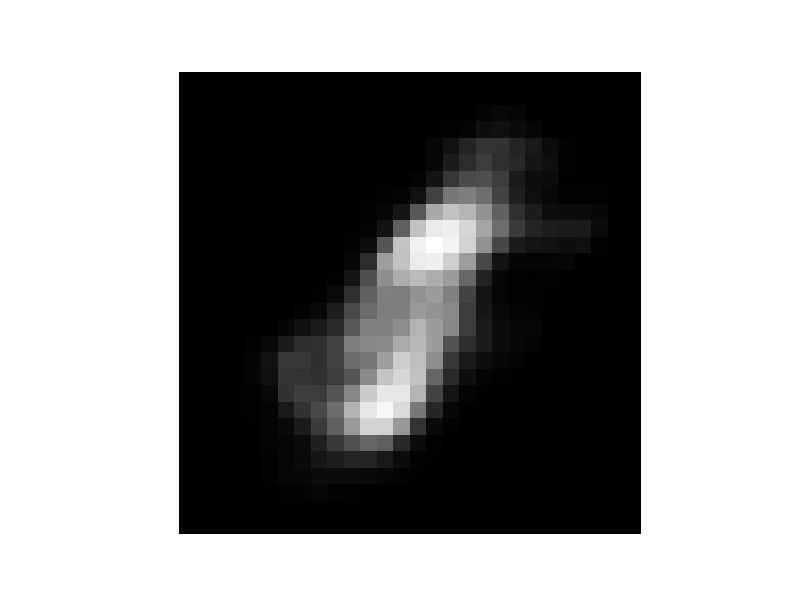

A Jupyter Widget

In [11]:
f, ax = plt.subplots(1, 1)
ax.axis('off')
n = 0
def update(**kwargs):
    vvals = np.array(list(kwargs.values()))
    print(vvals)
    t = np.zeros((batch_size, 10, 8))
    t[:, pn[n]] = vvals
    imgs = m_decoder.predict(t).reshape((-1, img_rows, img_cols))
    ax.imshow(imgs[0], cmap=cm.gray)
    f.canvas.draw()
    
tmp = pv[n]
sls = {'n%d' % (i,): widgets.FloatSlider(min=-1.0, max=1.0, step=0.25, value=tmp[i])
       for i in range(8)}

plt.show()

interact(update, **sls);